In [16]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy import linalg
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
import random
import time
import copy
from collections import defaultdict, Counter

from typing import List
import pickle
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats.stats import pearsonr

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k



def get_TPR(y_pred, y_true, p2i, i2p, y_p_test):
    gender = np.where(y_p_test == 1, 'f', 'm')
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        if prof_total_m > 0 and prof_total_f > 0:
            tpr_m = (good_m) / prof_total_m
            tpr_f = (good_f) / prof_total_f

            tprs[profession]["m"] = tpr_m
            tprs[profession]["f"] = tpr_f
            tprs_ratio.append(0)
            tprs_change[profession] = tpr_f - tpr_m
        else:
            print(f"profession {profession} missed in tpr-calc:\n\
                  number of {profession} male in test set {prof_total_m}\n\
                  number of {profession} female in test set {prof_total_f}\n\n")
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))
    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel(r'$GAP_{female,y}^{TPR}$', fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    plt.ylim(-0.4, 0.55)
    z = np.polyfit(sim_lst, tpr_lst, 1)
    p = np.poly1d(z)
    plt.plot(sim_lst,p(sim_lst),"r--")
    plt.savefig("{}_vs_bias_{}_bert".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()

def rms_diff(tpr_diff):
    
    return np.sqrt(np.mean(tpr_diff**2))

def tpr_exp(x_test, debiased_x_train, debiased_x_test, y_m_train, y_m_test, y_p_test, y_pred_before, p2i, i2p):

    tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_m_test, p2i, i2p, y_p_test)
    similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem)

    clf_debiased = LogisticRegression(warm_start = True, penalty = 'l2',
                             solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                             verbose = 5, n_jobs = 90, random_state = 1, max_iter = 100)

    clf_debiased.fit(debiased_x_train, y_m_train)
    print(f"\n\n\n================================================\
                \nSCORE: of profession classifier on debiased train dataset\
                \n{clf_debiased.score(debiased_x_train, y_m_train)}\
                \nSCORE: of profession classifier on debiased test dataset\
                \n{clf_debiased.score(debiased_x_test, y_m_test)}\
                \n================================================\n\n\n")
    y_pred_after_train = clf_debiased.predict(debiased_x_train)
    tprs, tprs_change_after_train, mean_ratio_after = get_TPR(y_pred_after_train, y_m_test, p2i, i2p, y_p_test)
    similarity_vs_tpr(tprs_change_after_train, None, "after", "TPR", prof2fem)
    
    y_pred_after_test = clf_debiased.predict(debiased_x_test)
    tprs, tprs_change_after_test, mean_ratio_after = get_TPR(y_pred_after_test, y_m_test, p2i, i2p, y_p_test)
    similarity_vs_tpr(tprs_change_after_test, None, "after", "TPR", prof2fem)

    change_vals_before = np.array(list((tprs_change_before.values())))
    change_vals_after_train = np.array(list(tprs_change_after_train.values()))
    change_vals_after_test = np.array(list(tprs_change_after_test.values()))

    print("rms-diff before: {}; rms-diff after for train set: {}; rms-diff after for test set: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after_train), rms_diff(change_vals_after_test)))

def get_TPR_emoji(y_main, y_hat_main, y_protected):
    
    all_y = list(Counter(y_main).keys())
    
    protected_vals = defaultdict(dict)
    for label in all_y:
        for i in range(2):
            used_vals = (y_main == label) & (y_protected == i)
            y_label = y_main[used_vals]
            y_hat_label = y_hat_main[used_vals]
            protected_vals['y:{}'.format(label)]['p:{}'.format(i)] = (y_label == y_hat_label).mean()
            
    diffs = {}
    for k, v in protected_vals.items():
        vals = list(v.values())
        diffs[k] = vals[0] - vals[1]
    return protected_vals, diffs

def rms(arr):
    return np.sqrt(np.mean(np.square(arr)))

    
p2i, i2p = load_dictionary("data/old/profession2index.txt")
g2i, i2g = load_dictionary("data/old/gender2index.txt")
prof2fem = {'professor': 0.4533699535765501, 'psychologist': 0.627327974906881, 'pastor': 0.2583668005354752, 'comedian': 0.21605667060212513, 'nurse': 0.9126009126009126, 'yoga_teacher': 0.825, 'attorney': 0.3766122913505311, 'photographer': 0.3563658099222953, 'composer': 0.16329625884732052, 'model': 0.7858407079646018, 'surgeon': 0.12832108535895986, 'physician': 0.4158485273492286, 'software_engineer': 0.17130434782608694, 'poet': 0.5133630289532294, 'painter': 0.47116788321167885, 'dj': 0.1636828644501279, 'journalist': 0.5159589626674266, 'architect': 0.23372781065088757, 'paralegal': 0.8618677042801557, 'dentist': 0.3672911787665886, 'personal_trainer': 0.4410377358490566, 'teacher': 0.5943396226415094, 'accountant': 0.3950091296409008, 'interior_designer': 0.7874493927125507, 'dietitian': 0.934412955465587, 'filmmaker': 0.3533007334963325, 'chiropractor': 0.3069908814589666, 'rapper': 0.09438775510204081}



In [7]:
saved_dataset = np.load(f"data/old/fair_biography_prof_gender/BERT/all.npz")

x_train = saved_dataset['x_train']
y_m_train = saved_dataset['y_m_train']
y_p_train = saved_dataset['y_p_train']

x_dev = saved_dataset['x_dev']
y_p_dev = saved_dataset['y_p_dev']
y_m_dev = saved_dataset['y_m_dev']

x_test = saved_dataset['x_test']
y_p_test = saved_dataset['y_p_test']
y_m_test = saved_dataset['y_m_test']

y_p_train_2d = np.asarray([y_p_train, - y_p_train + 1]).T

saved_model = scipy.io.loadmat('data/projection_matrix/BERT/old_paper.mat')
U_experiment = saved_model['U_experiment']
U_best = saved_model['U_best']

random.seed(0)
np.random.seed(0)

clf_original = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                         verbose = 5, n_jobs = 90, random_state = 1, max_iter = 7)
                         

clf_original.fit(x_train, y_m_train)
print(f"Score of profession classifier on original(biased) dataset \n{clf_original.score(x_test[:N_test, :], y_m_test[:N_test])}")

y_pred_before = clf_original.predict(x_test)

Correlation: 0.8911210577501446; p-value: 2.060745709586484e-10


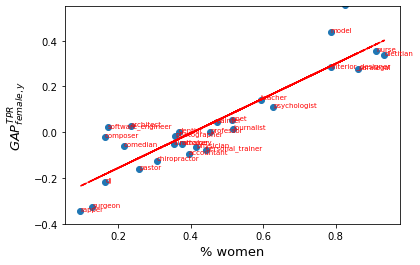

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 849 seconds


/work/sc066/sc066/shunshao/anaconda3/envs/ksal/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed: 14.2min finished





SCORE: of profession classifier on debiased train dataset                
0.8301193878368633                
SCORE: of profession classifier on debiased test dataset                
0.7807710977047362                



Correlation: -0.16995196470277413; p-value: 0.4381780602790577


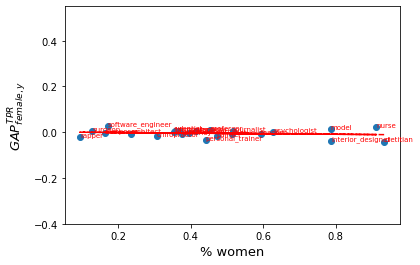

Correlation: 0.8092089830476259; p-value: 1.8577043588108266e-07


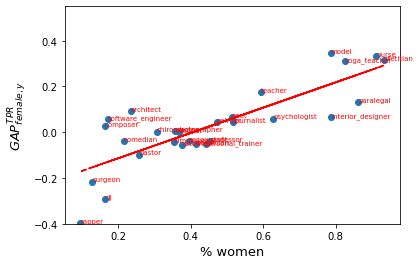

rms-diff before: 0.2138363635561522; rms-diff after for train set: 0.01773768924554149; rms-diff after for test set: 0.17102205277580257


In [30]:
removal = 2
u_r = U_experiment[:, removal:]
proj = u_r @ u_r.T
P = proj

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T


tpr_exp(x_test, debiased_x_train, debiased_x_test, \
        y_m_train, y_m_test, y_p_test, y_pred_before, p2i, i2p)


Correlation: 0.8911210577501446; p-value: 2.060745709586484e-10


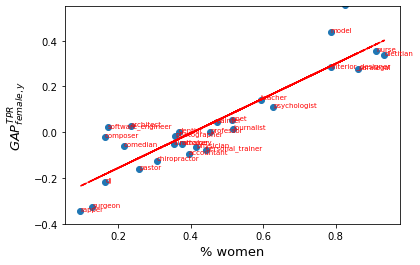

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28030246
Epoch 3, change: 0.15887126
Epoch 4, change: 0.12255900
Epoch 5, change: 0.09690081
Epoch 6, change: 0.07314624
Epoch 7, change: 0.05809540
Epoch 1, change: 1.00000000
Epoch 2, change: 0.20264101
Epoch 3, change: 0.14048989
Epoch 4, change: 0.09747685
Epoch 5, change: 0.07013387
Epoch 6, change: 0.07586446
Epoch 7, change: 0.05562925
Epoch 1, change: 1.00000000
Epoch 2, change: 0.20548315
Epoch 3, change: 0.12766235
Epoch 4, change: 0.08274410
Epoch 5, change: 0.06554013
Epoch 6, change: 0.05534338
Epoch 7, change: 0.04736664
Epoch 1, change: 1.00000000
Epoch 2, change: 0.20548315
Epoch 3, change: 0.12766235
Epoch 4, change: 0.08274410
Epoch 5, change: 0.06554013
Epoch 6, change: 0.05534338
Epoch 7, change: 0.04736664
Epoch 1, change: 1.00000000
Epoch 2, change: 0.24755249
Epoch 3, change: 0.13562587
Epoch 4, change: 0.08305347
Epoch 5, change: 0.06617381
Epoch 6, change: 0.05344929
Epoch 7, change: 0.04202174
Epoch 8, change: 0.0

KeyboardInterrupt: 

In [31]:
removal = 2
u_r = U_best[:, removal:]
proj = u_r @ u_r.T
P = proj

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T


tpr_exp(x_test, debiased_x_train, debiased_x_test, \
        y_m_train, y_m_test, y_p_test, y_pred_before, p2i, i2p)

In [ ]:
saved_dataset = np.load(f"data/old/fair_biography_prof_gender/FastText/all.npz")

x_train = saved_dataset['x_train']
y_m_train = saved_dataset['y_m_train']
y_p_train = saved_dataset['y_p_train']

x_dev = saved_dataset['x_dev']
y_p_dev = saved_dataset['y_p_dev']
y_m_dev = saved_dataset['y_m_dev']

x_test = saved_dataset['x_test']
y_p_test = saved_dataset['y_p_test']
y_m_test = saved_dataset['y_m_test']

y_p_train_2d = np.asarray([y_p_train, - y_p_train + 1]).T

saved_model = scipy.io.loadmat('data/projection_matrix/FastText/old_paper.mat')
U_experiment = saved_model['U_experiment']
U_best = saved_model['U_best']

random.seed(0)
np.random.seed(0)

clf_original = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                         verbose = 5, n_jobs = 90, random_state = 1, max_iter = 7)
                         

clf_original.fit(x_train, y_m_train)
print(f"Score of profession classifier on original(biased) dataset \n{clf_original.score(x_test[:N_test, :], y_m_test[:N_test])}")

y_pred_before = clf_original.predict(x_test)

In [ ]:
removal = 2
u_r = U_experiment[:, removal:]
proj = u_r @ u_r.T
P = proj

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T


tpr_exp(x_test, debiased_x_train, debiased_x_test, \
        y_m_train, y_m_test, y_p_test, y_pred_before, p2i, i2p)


In [ ]:
removal = 2
u_r = U_best[:, removal:]
proj = u_r @ u_r.T
P = proj

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T


tpr_exp(x_test, debiased_x_train, debiased_x_test, \
        y_m_train, y_m_test, y_p_test, y_pred_before, p2i, i2p)

In [36]:
print("=========================================== Start of 05_all ===========================================")

saved_dataset = np.load(f"data/old/fair_emoji_sent_race/0.5/all.npz")

x_train = saved_dataset['x_train']
y_m_train = saved_dataset['y_m_train']
y_p_train = saved_dataset['y_p_train']

x_dev = saved_dataset['x_dev']
y_p_dev = saved_dataset['y_p_dev']
y_m_dev = saved_dataset['y_m_dev']

saved_model = scipy.io.loadmat('data/projection_matrix/05_all/old_paper.mat')
U_experiment = saved_model['U_experiment']
U_best = saved_model['U_best']
print("=========================================== Start of 05_all assignment U ===========================================")

results = check_result(U_experiment, [2], x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev)
print(results)

print("=========================================== Start of 05_all best U ===========================================")

results = check_result(U_best, [2], x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev)
print(results)


defaultdict(dict,
            {2: {'p_acc': 0.49449862465616407,
              'biased_diff_tpr': 0.13599493058677786,
              'debiased_diff_tpr': 0.10104150451844744,
              'biased_acc': 0.7664416104026006,
              'debiased_acc': 0.7645661415353838}})

In [1]:
import sys
sys.path.append("../CCA_debiase/")
sys.path.append("../CCA_debiase/src")
import debias
import numpy as np
from sklearn.linear_model import LogisticRegression
import random
from collections import defaultdict, Counter
from typing import List
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats.stats import pearsonr
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import time

In [2]:
def rms(arr):
    return np.sqrt(np.mean(np.square(arr)))
    
def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k



def get_TPR(y_pred, y_true, p2i, i2p, y_p_test):
    gender = np.where(y_p_test == 1, 'f', 'm')
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        if prof_total_m > 0 and prof_total_f > 0:
            tpr_m = (good_m) / prof_total_m
            tpr_f = (good_f) / prof_total_f

            tprs[profession]["m"] = tpr_m
            tprs[profession]["f"] = tpr_f
            tprs_ratio.append(0)
            tprs_change[profession] = tpr_f - tpr_m
        else:
            print(f"profession {profession} missed in tpr-calc:\n\
                  number of {profession} male in test set {prof_total_m}\n\
                  number of {profession} female in test set {prof_total_f}\n\n")
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))
    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel(r'$GAP_{female,y}^{TPR}$', fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    plt.ylim(-0.4, 0.55)
    z = np.polyfit(sim_lst, tpr_lst, 1)
    p = np.poly1d(z)
    plt.plot(sim_lst,p(sim_lst),"r--")
    plt.savefig("{}_vs_bias_{}_bert".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()

def rms_diff(tpr_diff):
    
    return np.sqrt(np.mean(tpr_diff**2))

def tpr_exp(x_test, debiased_x_train, debiased_x_test, y_m_train, y_m_test, y_p_test, y_pred_before, p2i, i2p):

    tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, y_m_test, p2i, i2p, y_p_test)
    similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem)

    clf_debiased = LogisticRegression(warm_start = True, penalty = 'l2',
                             solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                             verbose = 5, n_jobs = 90, random_state = 1, max_iter = 100)

    clf_debiased.fit(debiased_x_train, y_m_train)
    print(f"\n\n\n================================================\
                \nSCORE: of profession classifier on debiased train dataset\
                \n{clf_debiased.score(debiased_x_train, y_m_train)}\
                \nSCORE: of profession classifier on debiased test dataset\
                \n{clf_debiased.score(debiased_x_test, y_m_test)}\
                \n================================================\n\n\n")
    y_pred_after_train = clf_debiased.predict(debiased_x_train)
    tprs, tprs_change_after_train, mean_ratio_after = get_TPR(y_pred_after_train, y_m_test, p2i, i2p, y_p_test)
    similarity_vs_tpr(tprs_change_after_train, None, "after", "TPR", prof2fem)
    
    y_pred_after_test = clf_debiased.predict(debiased_x_test)
    tprs, tprs_change_after_test, mean_ratio_after = get_TPR(y_pred_after_test, y_m_test, p2i, i2p, y_p_test)
    similarity_vs_tpr(tprs_change_after_test, None, "after", "TPR", prof2fem)

    change_vals_before = np.array(list((tprs_change_before.values())))
    change_vals_after_train = np.array(list(tprs_change_after_train.values()))
    change_vals_after_test = np.array(list(tprs_change_after_test.values()))

    print("rms-diff before: {}; rms-diff after for train set: {}; rms-diff after for test set: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after_train), rms_diff(change_vals_after_test)))

def get_TPR_deepmoji(y_main, y_hat_main, y_protected):
    
    all_y = list(Counter(y_main).keys())
    
    protected_vals = defaultdict(dict)
    for label in all_y:
        for i in range(2):
            used_vals = (y_main == label) & (y_protected == i)
            y_label = y_main[used_vals]
            y_hat_label = y_hat_main[used_vals]
            protected_vals['y:{}'.format(label)]['p:{}'.format(i)] = (y_label == y_hat_label).mean()
            
    diffs = {}
    for k, v in protected_vals.items():
        vals = list(v.values())
        diffs[k] = vals[0] - vals[1]
    return protected_vals, diffs

In [3]:
print("=========================================== Start of Biography Dataset ===========================================")

p2i, i2p = load_dictionary("data/old/profession2index.txt")
g2i, i2g = load_dictionary("data/old/gender2index.txt")
prof2fem = {'professor': 0.4533699535765501, 'psychologist': 0.627327974906881, 'pastor': 0.2583668005354752, 'comedian': 0.21605667060212513, 'nurse': 0.9126009126009126, 'yoga_teacher': 0.825, 'attorney': 0.3766122913505311, 'photographer': 0.3563658099222953, 'composer': 0.16329625884732052, 'model': 0.7858407079646018, 'surgeon': 0.12832108535895986, 'physician': 0.4158485273492286, 'software_engineer': 0.17130434782608694, 'poet': 0.5133630289532294, 'painter': 0.47116788321167885, 'dj': 0.1636828644501279, 'journalist': 0.5159589626674266, 'architect': 0.23372781065088757, 'paralegal': 0.8618677042801557, 'dentist': 0.3672911787665886, 'personal_trainer': 0.4410377358490566, 'teacher': 0.5943396226415094, 'accountant': 0.3950091296409008, 'interior_designer': 0.7874493927125507, 'dietitian': 0.934412955465587, 'filmmaker': 0.3533007334963325, 'chiropractor': 0.3069908814589666, 'rapper': 0.09438775510204081}

print("=========================================== Start of BERT ===========================================")

saved_dataset = scipy.io.loadmat('data/projection_matrix/BERT/old_paper.mat')
x_train = saved_dataset['best_iter_X']
y_p_train = saved_dataset['best_iter_original_Z']

saved_dataset = scipy.io.loadmat('data/old/BERT.mat')
x_dev = saved_dataset['x_dev']
y_p_dev = saved_dataset['y_p_dev']
y_m_dev = saved_dataset['y_m_dev']

x_test = saved_dataset['x_test']
y_p_test = saved_dataset['y_p_test']
y_m_test = saved_dataset['y_m_test']

saved_dataset = np.load('data/projection_matrix/BERT/old_paper_y_p_train.npz')
y_m_train = saved_dataset['y_m_train']

y_p_dev = y_p_dev.reshape((-1, ))
y_m_dev = y_m_dev.reshape((-1, ))
y_p_train = y_p_train[:, 0]
y_p_train = y_p_train.reshape((-1, ))
y_m_train = y_m_train.reshape((-1, ))
y_p_test = y_p_test.reshape((-1, ))
y_m_test = y_m_test.reshape((-1, ))

=========================================== Start of Biography Dataset ===========================================
=========================================== Start of BERT ===========================================


In [4]:
x_train.shape, y_p_train.shape, y_m_train.shape, x_dev.shape, y_p_dev.shape , y_m_dev.shape

((30000, 768), (30000,), (30000,), (11550, 768), (11550,), (11550,))

In [10]:
relevant_idx_train = y_m_train == 8
relevant_idx_dev = y_m_dev == 8

In [11]:
x_train[relevant_idx_train]

array([[-0.12482897,  0.03356773,  0.1236054 , ..., -0.53838801,
         0.91860729,  0.13197938],
       [-0.59334022,  0.22086598, -0.55451876, ...,  0.42952535,
         0.67205733, -0.25524524],
       [ 0.04906146, -0.1709239 ,  0.17991289, ..., -0.2165667 ,
         0.43702433,  0.34172592],
       ...,
       [-0.2287855 , -0.06744821,  0.02960668, ..., -0.20763612,
         0.42192128, -0.54273915],
       [-0.27720395,  0.07024824,  0.19508611, ..., -0.16296792,
         0.40294939, -0.19058378],
       [-0.4049989 , -0.40233558, -0.24761495, ...,  0.19096698,
         0.60444623,  0.01177378]])

In [12]:
x_dev[relevant_idx_dev]

array([[ 0.06825642,  0.00406375,  0.242547  , ..., -0.10528749,
         0.47306883,  0.00134006],
       [ 0.03298733,  0.11628118,  0.06418076, ..., -0.12553914,
         0.5961749 ,  0.05387819],
       [-0.07032021, -0.30232808,  0.31861138, ...,  0.11906028,
        -0.07829987,  0.35936216],
       ...,
       [ 0.17469877, -0.17766804,  0.439677  , ...,  0.28708568,
         0.39433587,  0.20887418],
       [ 0.6403455 , -0.36949852, -0.05983313, ..., -0.16163743,
         0.4426308 ,  0.3086289 ],
       [-0.28236443,  0.22111386,  0.41557044, ..., -0.31951952,
         0.28200287, -0.37972447]], dtype=float32)

In [6]:
x_dev.shape

(11550, 768)

In [4]:
start = time.time()
is_autoregressive = True
min_acc = 0.
dim = 768
n = 300
TYPE= "svm"
gender_clf = LinearSVC
params = {'penalty': 'l2', 'C': 0.01, 'fit_intercept': True, 'class_weight': None, "dual": False}
    
P,rowspace_projections, Ws = debias.get_debiasing_projection(gender_clf, params, n, dim, is_autoregressive, min_acc,
                                    x_train, y_p_train, x_dev, y_p_dev,
                                    Y_train_main=y_m_train, Y_dev_main=y_m_dev, by_class = True)
print("time: {}".format(time.time() - start))





iteration: 299, accuracy: 0.5129151291512916: 100%|█████████████████████████████████████████████████████████████████████████████| 300/300 [05:59<00:00,  1.20s/it]


time: 360.7653434276581


NameError: name 'y_pred_before' is not defined

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


max_iter reached after 25 seconds
Score of profession classifier on original(biased) dataset 
0.7865612648221344


/work/sc066/sc066/shunshao/anaconda3/envs/ksal/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:   24.5s finished


Correlation: 0.8868905041838208; p-value: 3.2997804523961903e-10


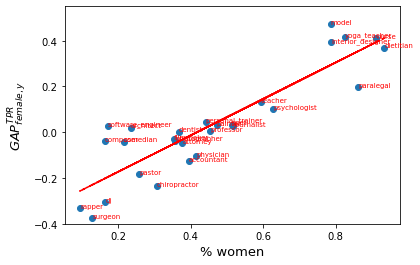

[Parallel(n_jobs=90)]: Using backend ThreadingBackend with 90 concurrent workers.


convergence after 78 epochs took 254 seconds



SCORE: of profession classifier on debiased train dataset                
0.7046333333333333                
SCORE: of profession classifier on debiased test dataset                
0.6469384924762499                





[Parallel(n_jobs=90)]: Done   1 out of   1 | elapsed:  4.2min finished


Correlation: 0.20043246444178253; p-value: 0.4106495056226134


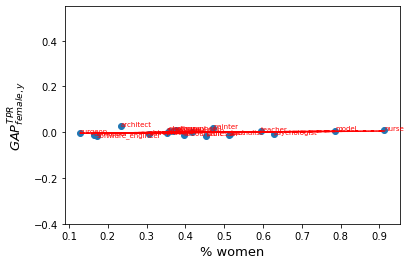

Correlation: 0.2868955972633461; p-value: 0.15531200382794713


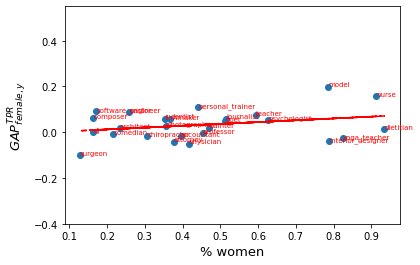

rms-diff before: 0.22369200684823834; rms-diff after for train set: 0.011574428988523221; rms-diff after for test set: 0.07261375649100146


In [5]:
random.seed(0)
np.random.seed(0)

clf_original = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "saga", multi_class = 'multinomial', fit_intercept = False,
                         verbose = 5, n_jobs = 90, random_state = 1, max_iter = 7)
                         

clf_original.fit(x_train, y_m_train)
print(f"Score of profession classifier on original(biased) dataset \n{clf_original.score(x_test, y_m_test)}")

y_pred_before = clf_original.predict(x_test)

debiased_x_train = P.dot(x_train.T).T
debiased_x_dev = P.dot(x_dev.T).T
debiased_x_test = P.dot(x_test.T).T

tpr_exp(x_test, debiased_x_train, debiased_x_test, \
        y_m_train, y_m_test, y_p_test, y_pred_before, p2i, i2p)